# Multi-task classification: Random forest and (Multitask)Lasso

### Importing libraries

In [1]:
import os
import urllib
import random
import warnings
import itertools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, binarize
from sklearn.feature_selection import SelectKBest
from statsmodels.robust.scale import mad

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LassoCV
from sklearn.linear_model import MultiTaskLassoCV

In [2]:
%matplotlib inline
plt.style.use('seaborn-notebook')

### Load Data

In [3]:
%%time
path = os.path.join('..','download', 'expression-matrix.tsv.bz2')
X = pd.read_table(path, index_col=0)

Wall time: 2min 25s


In [4]:
%%time
path = os.path.join('..','download', 'mutation-matrix.tsv.bz2')
Y = pd.read_table(path, index_col=0)

Wall time: 1min 27s


In [5]:
# Target_therapy file - https://www.mycancergenome.org/content/molecular-medicine/overview-of-targeted-therapies-for-cancer/ 

TT = pd.read_csv('Target_therapy.csv')

TT['Entrez_gene_id'] = TT['Entrez_gene_id'].astype(str)

print(TT)

               Drug Entrez_gene_id Gene_symbol
0          Afatinib           1956        EGFR
1          Afatinib           2064        HER2
2          Axitinib           3815         KIT
3          Axitinib           5159      PDGFRB
4          Axitinib           2321        FLT1
5          Axitinib           3791         KDR
6          Axitinib           2324        FLT4
7      Cabozantinib           2322        FLT3
8      Cabozantinib           3815         KIT
9      Cabozantinib           4233         MET
10     Cabozantinib           5979         RET
11     Cabozantinib           3791         KDR
12       Crizotinib            238         ALK
13       Crizotinib           4233         MET
14       Crizotinib           6098        ROS1
15         Imatinib           3815         KIT
16         Imatinib           5159      PDGFRB
17         Imatinib             25         ABL
18      Palbociclib           1019        CDK4
19      Palbociclib           1021        CDK6
20        Paz

In [6]:
# the list of genes that appear in the file

genes = TT.set_index('Entrez_gene_id')['Gene_symbol'].to_dict()

for k, v in genes.items():
    print (k, ':', v)

1956 : EGFR
2064 : HER2
3815 : KIT
5159 : PDGFRB
2321 : FLT1
3791 : KDR
2324 : FLT4
2322 : FLT3
4233 : MET
5979 : RET
238 : ALK
6098 : ROS1
25 : ABL
1019 : CDK4
1021 : CDK6
2263 : FGFR1-3
5894 : RAF1
5727 : PTCH1
6608 : SMO
5281 : PIGF
7422 : VEGFA
7423 : VEGFB


### Definition of functions and classifiers (mono and multitask)

In [7]:
#functions for data preprocessing and figure labels

def fs_mad(x, y):
    """
    Get the median absolute deviation (MAD) for each column of x
    """
    scores = mad(x) 
    return scores, np.array([np.NaN]*len(scores))
# select the top features with the highest MAD
feature_select = SelectKBest(fs_mad, k=2000)

pipeline = make_pipeline(
    feature_select,  # Feature selection
    StandardScaler(),  # Feature scaling
    )

def autolabel(rects,ay):
    # attach some text labels
    for rect in rects:
        width = rect.get_width()
        ay.text(1.05*width, rect.get_y() + rect.get_height()/2., 
                '%.2f' % width,
                ha='center', va='bottom')
        

In [27]:
# Mono-task classifiers, random forests and Lasso. Lasso results will be binarized. 

Classifiers_mono = {
    "Random forest": RandomForestClassifier(max_depth=100, min_samples_split=2, n_estimators=20, random_state=0),
    "LassoCV": LassoCV(alphas=[.01, .1, 1, 10],tol=0.01),
}


In [28]:
# Following methods allow multi-task implementation: Extra trees, Knn, Random forests and MultiTask Lasso. 
# Extra Tres and KNN will not be used in this notebook.

Classifiers_multi = {
    "Random forest": RandomForestClassifier(max_depth=100, min_samples_split=2, n_estimators=20, random_state=0),
    "MultiTaskLassoCV": MultiTaskLassoCV(alphas=[.01, .1, 1, 10],tol=0.01),
}


### Training and testing dataset

In [29]:
# all targeted genes, needed for comparison, store them in y

y=Y[list(genes.keys())] 

# Using same training set for all targets
# Set aside 10% of the data for testing, this can only be done where the number of mutations is large enough
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
'Size: {:,} features, {:,} training samples, {:,} testing samples'.format(len(X.columns), len(X_train), len(X_test))

features_train=pipeline.fit_transform(X=X_train, y=y_train) 
features_test=pipeline.transform(X=X_test)

### Results for all genes

C:\Users\bjokanov\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
C:\Users\bjokanov\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


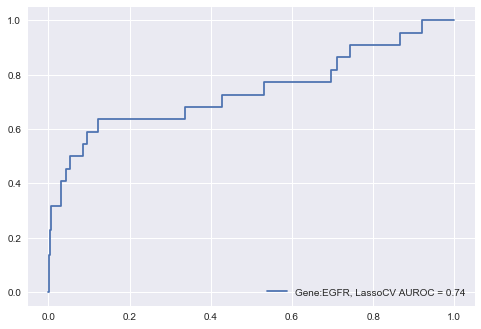

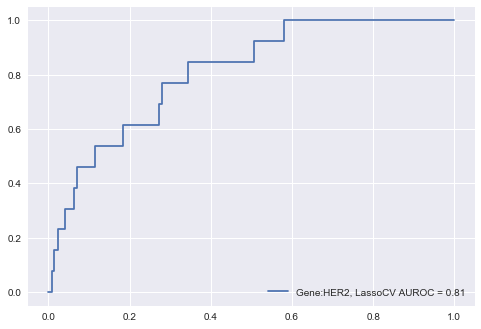

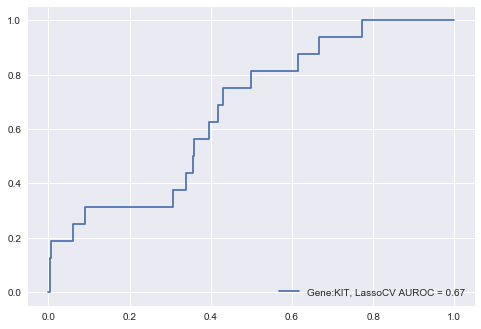

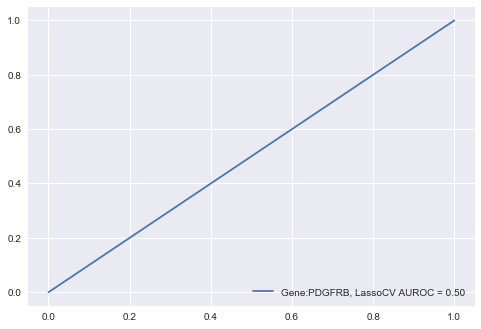

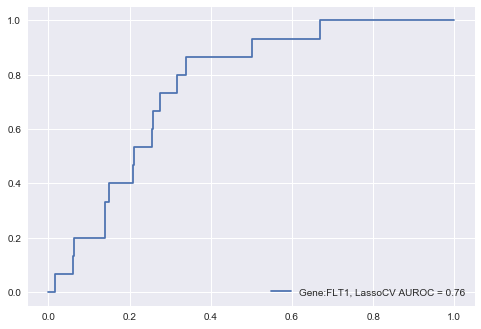

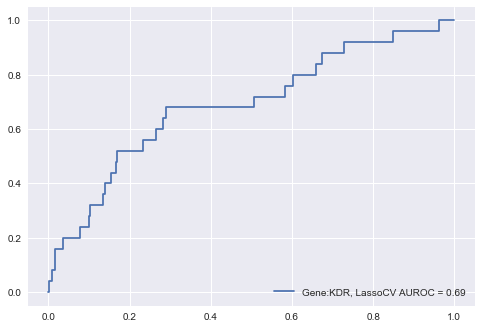

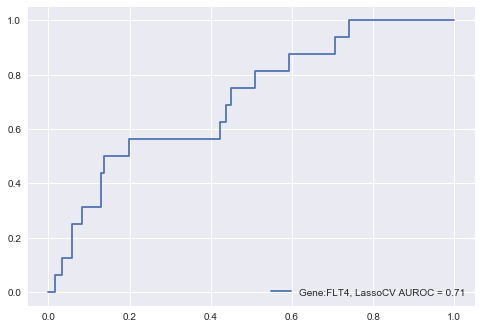

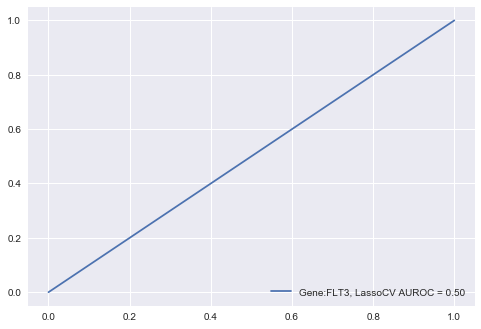

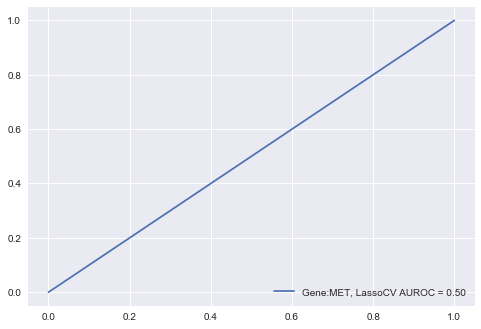

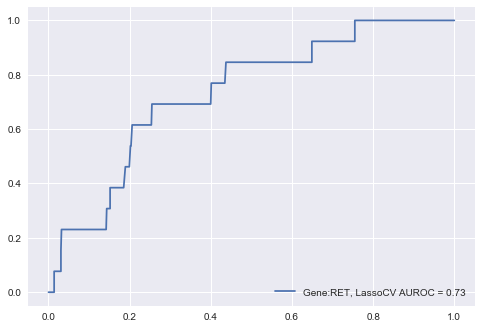

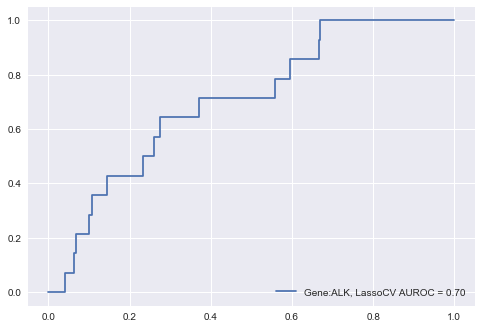

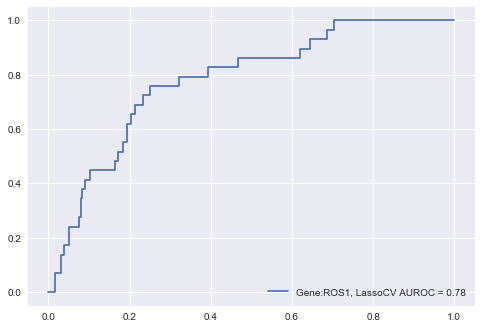

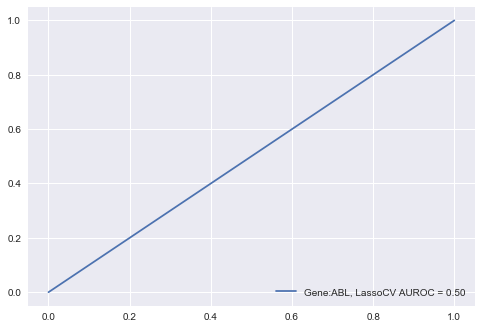

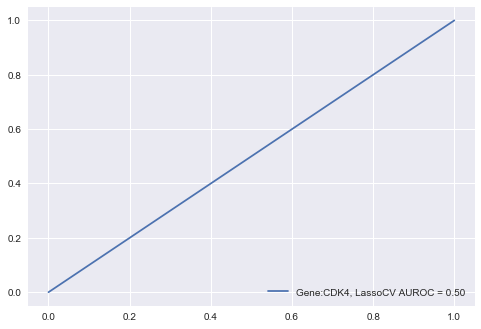

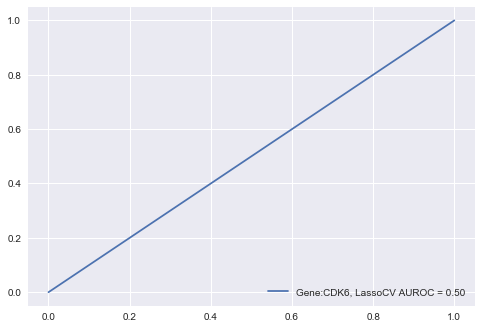

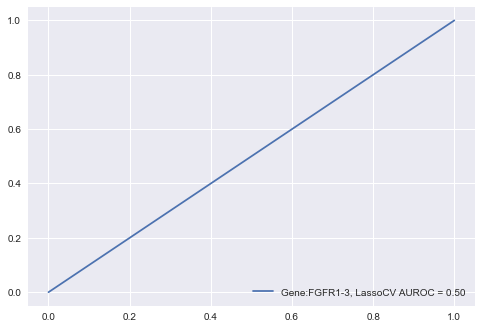

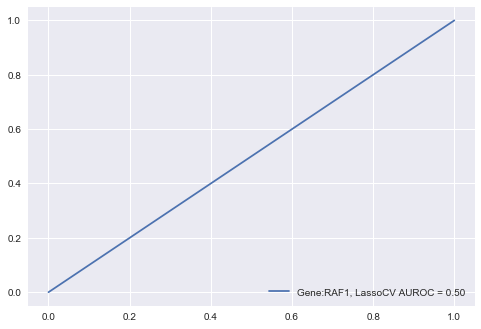

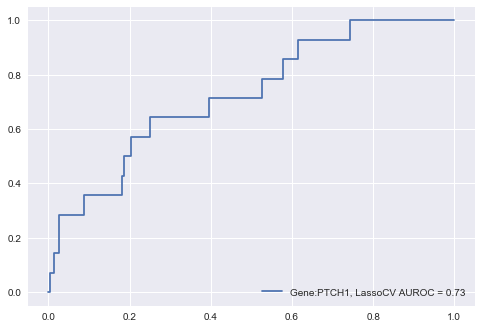

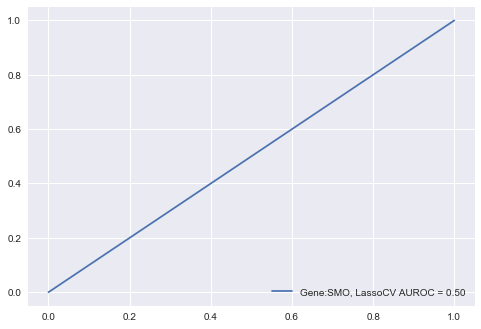

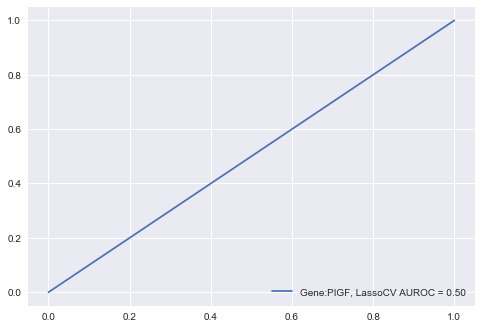

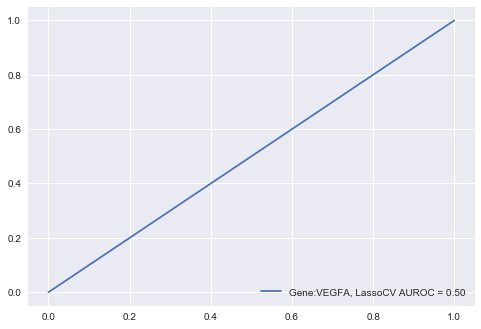

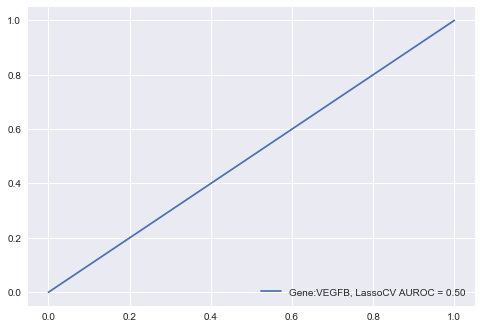

In [30]:
# Results for all genes when observed separately, accuracy score and Auroc-s are used for evaluation

as_RF =[]
as_L = []

for GENE in list(genes.keys()):
    
    y_train_each = y_train[GENE]
    true_label = list(y_test[GENE])
    
    y_test_predict = dict()
    for name, classifier in Classifiers_mono.items():
        classifier.fit(features_train, y_train_each)
        y_test_predict[name] = classifier.predict(features_test)
        
    
    result_RF = y_test_predict['Random forest']
    result_L = binarize(y_test_predict['LassoCV'].reshape(-1,1), threshold=0.5)     
    as_RF.append(accuracy_score(true_label,result_RF))
    as_L.append(accuracy_score(true_label,result_L))
    fpr, tpr, thresholds = roc_curve(true_label, y_test_predict['LassoCV'])
    auroc = auc(fpr, tpr)
    plt.figure() 
    plt.plot(fpr, tpr, label='Gene:%s, LassoCV AUROC = %0.2f' % (genes[GENE],auroc))
    plt.legend(loc="lower right")
   

In [31]:
# let's see what is the best alpha for LassoCV

classifier.alpha_

10.0

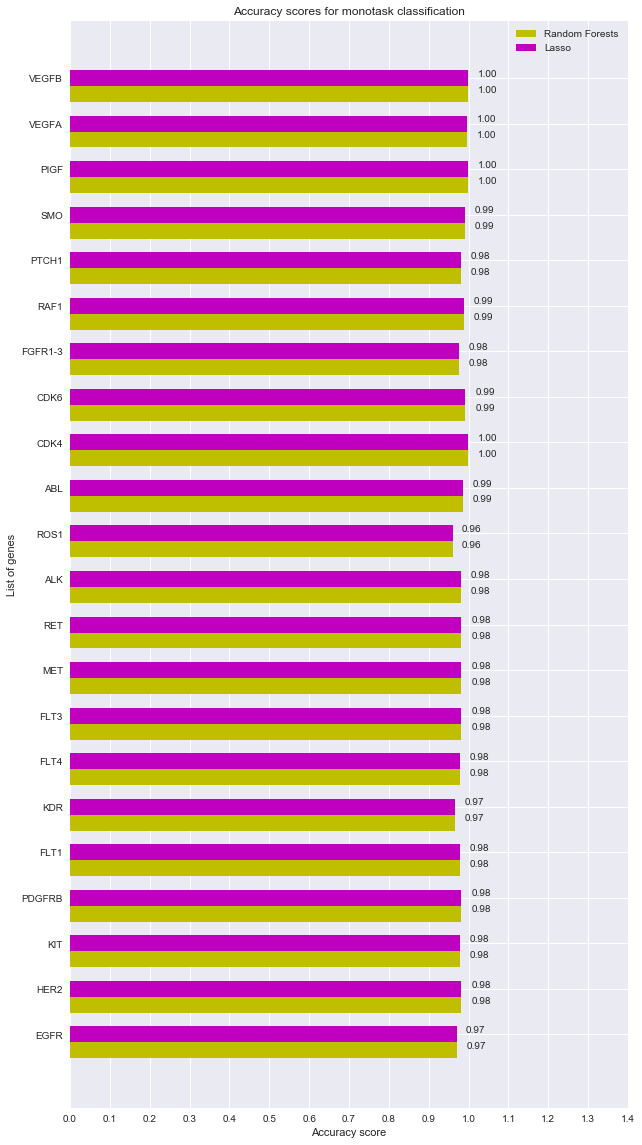

In [32]:
# plot for all genes  

width = 0.35       # the width of the bars

ind_genes = np.arange(len(as_RF))  # the y locations for the groups

fig_genes, as_genes = plt.subplots(figsize=(10, 20))

results_as_RF = as_genes.barh(ind_genes, as_RF, width, color='y')

results_as_L = as_genes.barh(ind_genes + width, as_L, width, color='m')

# add some text for labels, title and axes ticks
as_genes.set_xlabel('Accuracy score')
as_genes.set_title('Accuracy scores for monotask classification')
as_genes.set_ylabel('List of genes')
as_genes.set_yticks(ind_genes + width)
as_genes.set_yticklabels(genes.values())
as_genes.set_xticks(np.arange(0, 1.5, 0.1))

as_genes.legend((results_as_RF, results_as_L), ('Random Forests', 'Lasso'))

autolabel(results_as_RF,as_genes)
autolabel(results_as_L,as_genes)
 
plt.show()


### Results for specific drug (agent) 

In [33]:
# choose the drug

drug = 'Afatinib'

In [34]:
# genes targeted by this drug

loc=TT[TT.Drug== drug].index       

df=TT.iloc[loc]

genes_Agent = df.set_index('Entrez_gene_id')['Gene_symbol'].to_dict()

print(genes_Agent)

{'1956': 'EGFR', '2064': 'HER2'}


In [35]:
# classification

y_train_Agent = y_train[list(genes_Agent.keys())] 
y_test_Agent = y_test[list(genes_Agent.keys())] 

y_test_predict_Agent = dict()
for name, classifier in Classifiers_multi.items():
    classifier.fit(features_train, y_train_Agent)
    y_test_predict_Agent[name] = classifier.predict(features_test)
    
res_RF_Agent = y_test_predict_Agent['Random forest']
res_MTL_Agent = y_test_predict_Agent['MultiTaskLassoCV'] 
        

In [36]:
# best alpha - only valid for MultitaskLassoCV

classifier.alpha_

0.01

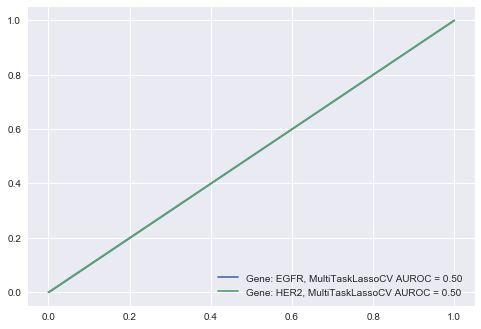

In [37]:
# computing the scores

as_RF_Agent =[]
as_MTL_Agent = []

x = 0
for GENE in list(genes_Agent.keys()):
    result_RF_Agent = res_RF_Agent[:,x]
    result_MTL_Agent = binarize(res_MTL_Agent[:,x].reshape(-1,1), threshold=0.5)
    x = x + 1
    true_label_Agent = y_test_Agent[GENE]
    as_RF_Agent.append(accuracy_score(true_label_Agent,result_RF_Agent))
    as_MTL_Agent.append(accuracy_score(true_label_Agent,result_MTL_Agent))
    fpr, tpr, thresholds = roc_curve(true_label_Agent, result_RF_Agent)
    auroc = auc(fpr, tpr)    
    #plt.figure(x)
    plt.plot(fpr, tpr, label='Gene: %s, MultiTaskLassoCV AUROC = %0.2f ' % (genes_Agent[GENE], auroc) )
    plt.legend(loc="lower right")

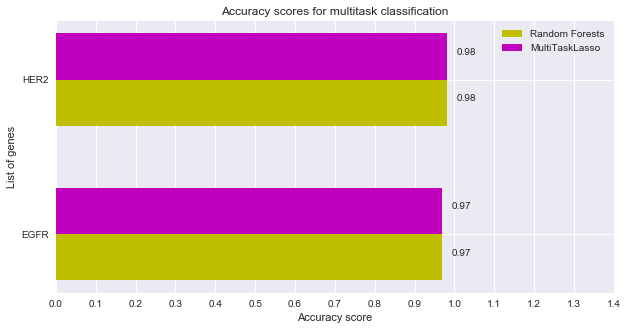

In [38]:
# plot for accuracy scores - Agent genes

width = 0.3       # the width of the bars

ind_genes_agent = np.arange(len(as_RF_Agent))  # the x locations for the groups

fig_genes_agent, as_genes_agent = plt.subplots(figsize=(10, 5))

ascores_RF_Agent = as_genes_agent.barh(ind_genes_agent, as_RF_Agent, width, color='y')

ascores_MTL_Agent = as_genes_agent.barh(ind_genes_agent + width, as_MTL_Agent, width, color='m')

# add some text for labels, title and axes ticks
as_genes_agent.set_xlabel('Accuracy score')
as_genes_agent.set_title('Accuracy scores for multitask classification')
as_genes_agent.set_ylabel('List of genes')
as_genes_agent.set_yticks(ind_genes_agent + .5*width)
as_genes_agent.set_yticklabels(genes_Agent.values())
as_genes_agent.set_xticks(np.arange(0, 1.5, 0.1))

as_genes_agent.legend((ascores_RF_Agent, ascores_MTL_Agent), ('Random Forests', 'MultiTaskLasso'))

autolabel(ascores_RF_Agent,as_genes_agent)
autolabel(ascores_MTL_Agent,as_genes_agent)


plt.show() 